(mmm_roas)=
# Case Study: Unobserved Confounders, ROAS and Lift Tests

### The Importance of Calibration in Media Mix Models

When working with Media Mix Models (MMMs), calibration with lift tests is not just a technical step — it's essential for making these models reliable and actionable. Lift tests serve as a reality check, grounding the model's predictions in real-world outcomes. This process is particularly important because MMMs often rely on data that is both noisy and limited in scope, making accurate predictions difficult.

### Why MMMs Need to Be Causal Models

The true power of MMMs lies in their ability to guide decisions based on potential changes in marketing strategy. For instance, a marketer might ask, "What impact would reducing the budget for channel X by 50% have on overall sales?" To answer such questions, MMMs must be developed as *causal models*—models that can predict the effects of specific interventions. 

Creating a causal model involves constructing a well-defined *directed acyclic graph* (DAG). A DAG is a visual representation of the relationships between different variables in the model, helping to ensure that the right covariates (or control variables) are included. This isn't just about throwing in every available piece of data; it's about selecting variables that genuinely contribute to understanding the causal relationships in your marketing activities.

### The Challenge of Unobserved Confounders

Even with a well-constructed DAG, unobserved confounders can pose a significant problem. These are variables that influence both the treatment (e.g., spending on a particular marketing channel) and the outcome (e.g., sales) but are not included in the model. Their omission can lead to biased estimates, which in turn can result in poor decision-making. Unfortunately, unobserved confounders are almost inevitable in any real-world scenario.

### A Recent Innovation: Calibrating MMMs with Bayesian Priors and Lift Tests

In theory, methods like instrumental variables can help address the issue of unobserved confounders. An instrumental variable is a variable that is correlated with the treatment but not with the outcome, except through the treatment. However, finding good instruments is notoriously difficult, making this solution less practical.

An alternative, more practical solution is to calibrate the MMM using lift tests. Lift tests are experiments that measure the incremental effect of a marketing intervention, such as a temporary increase in ad spend on a specific channel. By calibrating the model with the results of these tests, we can reduce the bias introduced by unobserved confounders. Bayesian methods are particularly well-suited for this approach because they allow us to incorporate prior knowledge—information we have before analyzing the data—into the model. This can significantly improve the model's accuracy, even before we start crunching the numbers.

A recent paper, [Media Mix Model Calibration With Bayesian Priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/) by Zhang et al. (2024), proposes a novel approach to calibrating MMMs. Instead of using the traditional beta (or regression) coefficients for each channel, the authors suggest parametrizing the model in terms of *return on ad spend* (ROAS). 

The concept is straightforward: express the beta coefficients in terms of ROAS, and then substitute these into a standard MMM equation. This method simplifies the calibration process and can partially mitigate biases comming from unobserved confounders and noise in the data.

### Practical Application: Implementing the Method in PyMC

In the blog post [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/), [Juan Orduz](https://juanitorduz.github.io) provides a comprehensive implementation of this method using PyMC. This work demonstrates how this calibration approach can yield more accurate estimates, even when dealing with unobserved confounders. However, despite its strengths, this method has a limitation: it doesn't automatically improve when additional lift tests are added. The authors of the paper suggest aggregating the results of multiple lift tests by taking a weighted average of the ROAS estimates from each experiment.

### A New Approach: Refining MMMs with Custom Likelihood Functions

While the method proposed by Zhang et al. is effective, it could be more efficient in leveraging the results of lift tests. Running these experiments requires significant planning and resources, so it's important to maximize their value.

To address this, we propose an alternative approach. Instead of directly reparametrizing the model in terms of ROAS, we suggest adding additional likelihood functions based on the saturation curves of the marketing channels. Saturation curves describe how the effectiveness of a marketing channel diminishes as spending increases. By calibrating the model through these curves using lift test results, we can continuously refine our estimates as more experiments are conducted. This approach allows us to make better use of the data from lift tests, leading to more accurate and reliable MMMs over time.

### Demonstrating the Approach: Results and Implementation

In our notebook, we replicate the results from the blog post [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/) using the PyMC-Marketing framework. This framework allows us to incorporate lift tests through custom likelihood functions, providing a more nuanced calibration of the MMM. By continuously refining our estimates as new data becomes available, this approach offers a dynamic and robust solution to the challenges posed by unobserved confounders in marketing mix modeling.

For those interested in diving deeper, we encourage you to explore a detailed description of the method in our notebook {ref}`mmm_lift_test`, where we walk through the process step by step.

## Prepare Notebook

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pymc_extras.prior import Prior

from pymc_marketing.hsgp_kwargs import HSGPKwargs
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/time_slice_cross_validation.py:32: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml


In [2]:
seed: int = sum(map(ord, "mmm_roas_notebook"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We read the data, which is available in the `data` of our repository.

In [3]:
data_path = data_dir / "mmm_roas_data.csv"

raw_df = pd.read_csv(data_path, parse_dates=["date"])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int64         
 2   quarter               131 non-null    object        
 3   trend                 131 non-null    float64       
 4   cs                    131 non-null    float64       
 5   cc                    131 non-null    float64       
 6   seasonality           131 non-null    float64       
 7   z                     131 non-null    float64       
 8   x1                    131 non-null    float64       
 9   x2                    131 non-null    float64       
 10  epsilon               131 non-null    float64       
 11  x1_adstock            131 non-null    float64       
 12  x2_adstock            131 non-null    float64       
 13  x1_adstock_saturated

There are many columns in the dataset. We will explain the below. For now, that is important is for modeling purposes we will only use the `date`, `x1`, `x2` (channels)and `y` (target) columns.

In [4]:
model_df = raw_df.copy().filter(["date", "x1", "x2", "y"])

## Data Generating Process  

In the original [blog post](https://juanitorduz.github.io/mmm_roas/), the authors generate the data using the following DAG.

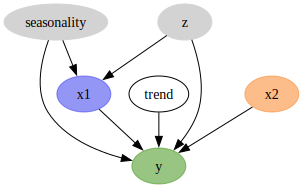

In [5]:
g = gr.Digraph()
g.node(name="seasonality", label="seasonality", color="lightgray", style="filled")
g.node(name="trend", label="trend")
g.node(name="z", label="z", color="lightgray", style="filled")
g.node(name="x1", label="x1", color="#2a2eec80", style="filled")
g.node(name="x2", label="x2", color="#fa7c1780", style="filled")
g.node(name="y", label="y", color="#328c0680", style="filled")
g.edge(tail_name="seasonality", head_name="x1")
g.edge(tail_name="z", head_name="x1")
g.edge(tail_name="x1", head_name="y")
g.edge(tail_name="seasonality", head_name="y")
g.edge(tail_name="trend", head_name="y")
g.edge(tail_name="z", head_name="y")
g.edge(tail_name="x2", head_name="y")
g

We are interested in the effect of the `x1` and `x2` channels on the `y` variable. We have additional covariates like yearly seasonality and a a  non-linear trend component. In addition, there is an unobserved confounder `z` that affects both the channels and the target variable. This variable introduces a bias in the estimates if we do not account for it. However, for this problem we are going to assume that we do not have access to the `z` variable (hence, unobserved).

In the `raw_df` we have all all the columns needed in the data generating process to obtain the target variable `y`. For example, the `x1_adstock_saturated` column is the result of applying the adstock function and then the saturation to the `x1` channel.

The target variable `y` is generated as  

```
y = amplitude * (trend + seasonality + z + x1_effect + x2_effect + epsilon)
```

where `epsilon` is a Gaussian noise and `amplitude` is a set to $100$.

The variables `y01` and `y02` are the target variable `y` without the effect of the `x1` and `x2` channels, respectively. Hence

```
y01 = {amplitude} * (trend + seasonality + z + x2_effect + epsilon)
y02 = {amplitude} * (trend + seasonality + z + x1_effect + epsilon)
```

 For details on the data generating process, please refer to the [blog post](https://juanitorduz.github.io/mmm_roas/).

From the variables `y01` and `y02` we can compute the true ROAS for the `x1` and `x2` channels for the whole period ( for simplicity we ignore the carryover effect).

In [6]:
true_roas_x1 = (raw_df["y"] - raw_df["y01"]).sum() / raw_df["x1"].sum()
true_roas_x2 = (raw_df["y"] - raw_df["y02"]).sum() / raw_df["x2"].sum()

print(f"True ROAS for x1: {true_roas_x1:.2f}")
print(f"True ROAS for x2: {true_roas_x2:.2f}")

True ROAS for x1: 93.39
True ROAS for x2: 171.41


We would like to recover the true ROAS for the `x1` and `x2` channels using a media mix model.

Before jumping into the model, let's plot the target data and the channels data to understand it better.

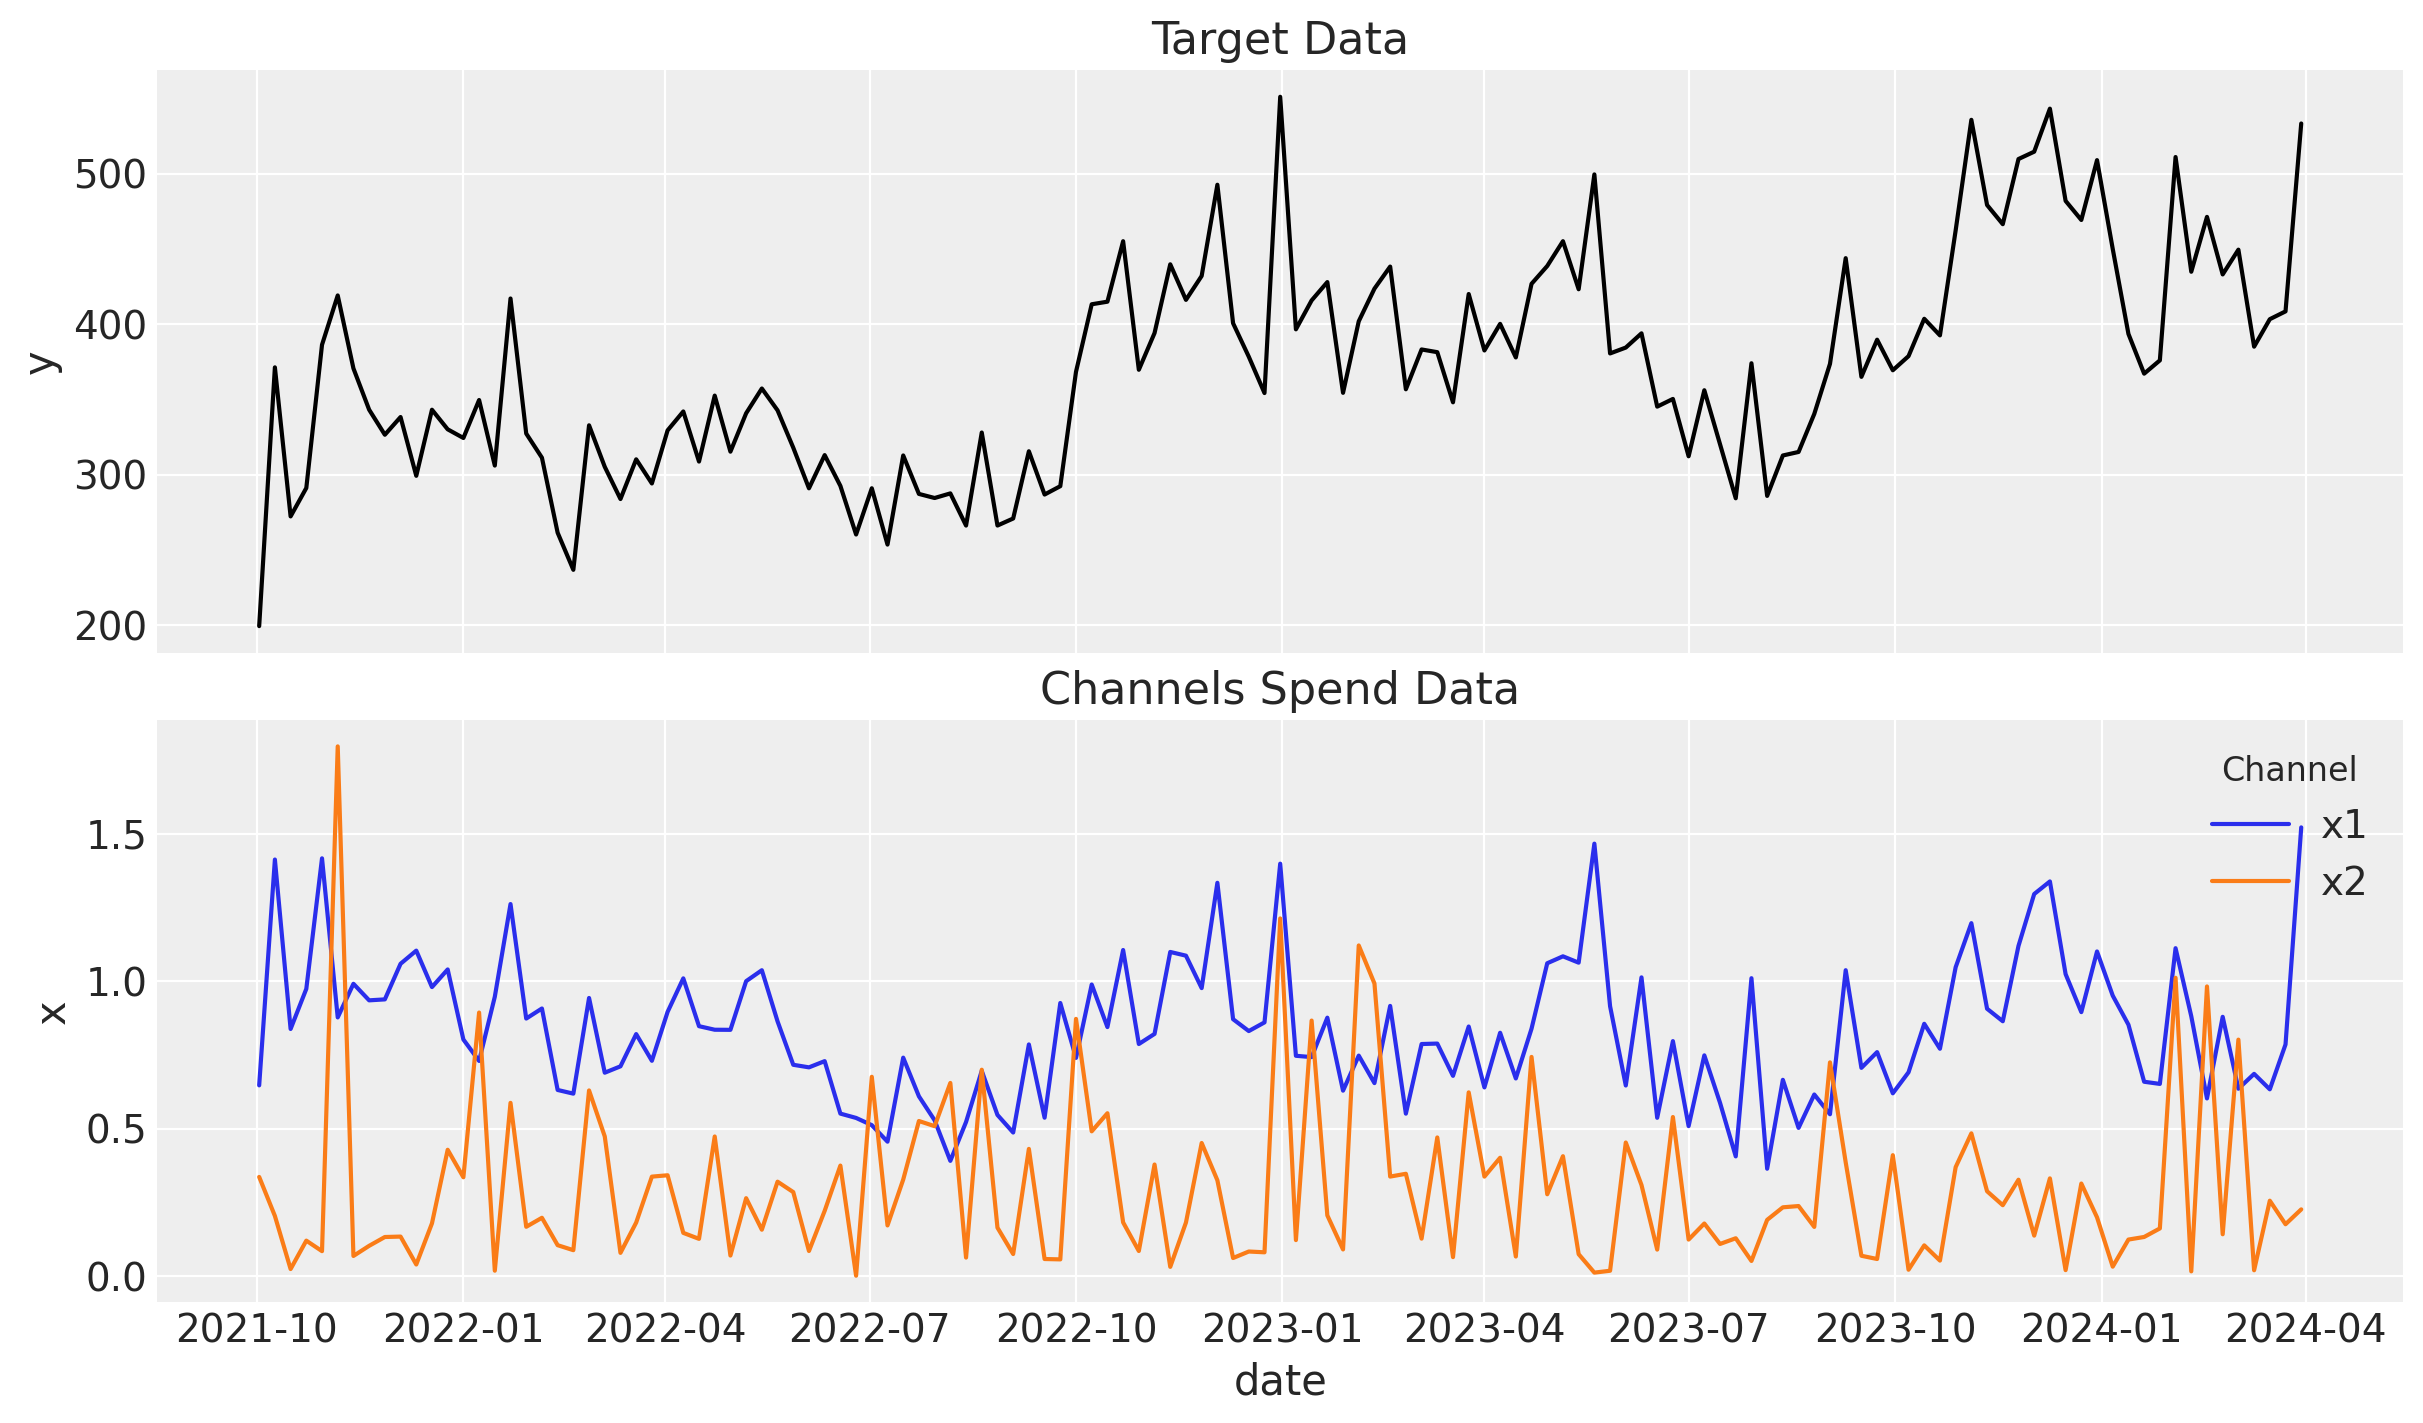

In [7]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    sharey=False,
    layout="constrained",
)

sns.lineplot(
    x="date",
    y="y",
    data=model_df,
    color="black",
    ax=ax[0],
)
ax[0].set_title("Target Data")

model_df.melt(
    id_vars=["date"], value_vars=["x1", "x2"], var_name="channel", value_name="x"
).pipe(
    (sns.lineplot, "data"),
    x="date",
    y="x",
    hue="channel",
    ax=ax[1],
)
ax[1].legend(title="Channel", title_fontsize=12)
ax[1].set_title("Channels Spend Data");

## Baseline Model

To begin with, we fit a media mix model, without including the unobserved confounder `z`, using a saturated adstock and logistic saturation using PyMC-Marketing's API. For more details on the model, please refer to the {ref}`mmm_example` notebook. As we discuss in that notebook, without any lift test information, a good starting point is to pass the cost share into the prior of the beta channel coefficients.

In [8]:
cost_share = model_df[["x1", "x2"]].sum() / model_df[["x1", "x2"]].sum().sum()

We can specify the model configuration as follows (see the {ref}`model_configuration` notebook for more details): 

In [9]:
model_config = {
    "intercept": Prior("Normal", mu=200, sigma=20),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
    "gamma_fourier": Prior("Normal", mu=0, sigma=2, dims="fourier_mode"),
    "intercept_tvp_config": HSGPKwargs(
        m=100, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None
    ),
    "adstock_alpha": Prior("Beta", alpha=2, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=2, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=cost_share.to_numpy(), dims="channel"),
}

Observe that we are going to use a Gaussian process to model the non-linear trend component (see {ref}`mmm_tv_intercept`).

Let's fit the model!

In [10]:
%%time

mmm = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    target_column="y",
    time_varying_intercept=True,
    time_varying_media=False,
    yearly_seasonality=5,
    model_config=model_config,
)

y = model_df["y"]
X = model_df.drop(columns=["y"])

fit_kwargs = {
    "tune": 1_500,
    "chains": 4,
    "draws": 1_000,
    "nuts_sampler": "nutpie",
    "target_accept": 0.95,
    "random_seed": rng,
}

mmm.build_model(X, y)
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "fourier_contribution",
        "intercept_contribution",
    ]
)
_ = mmm.fit(X, y, **fit_kwargs)
_ = mmm.sample_posterior_predictive(
    X, extend_idata=True, combined=True, random_seed=rng
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,0,0.09,63
,2500,0,0.08,63
,2500,0,0.07,63
,2500,0,0.08,63


Output()

Sampling: [y]


Output()

CPU times: user 1min 2s, sys: 1.01 s, total: 1min 3s
Wall time: 24 s


Let's verify that we do not have divergent transitions.

In [11]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

Next, we look into the model components contributions:

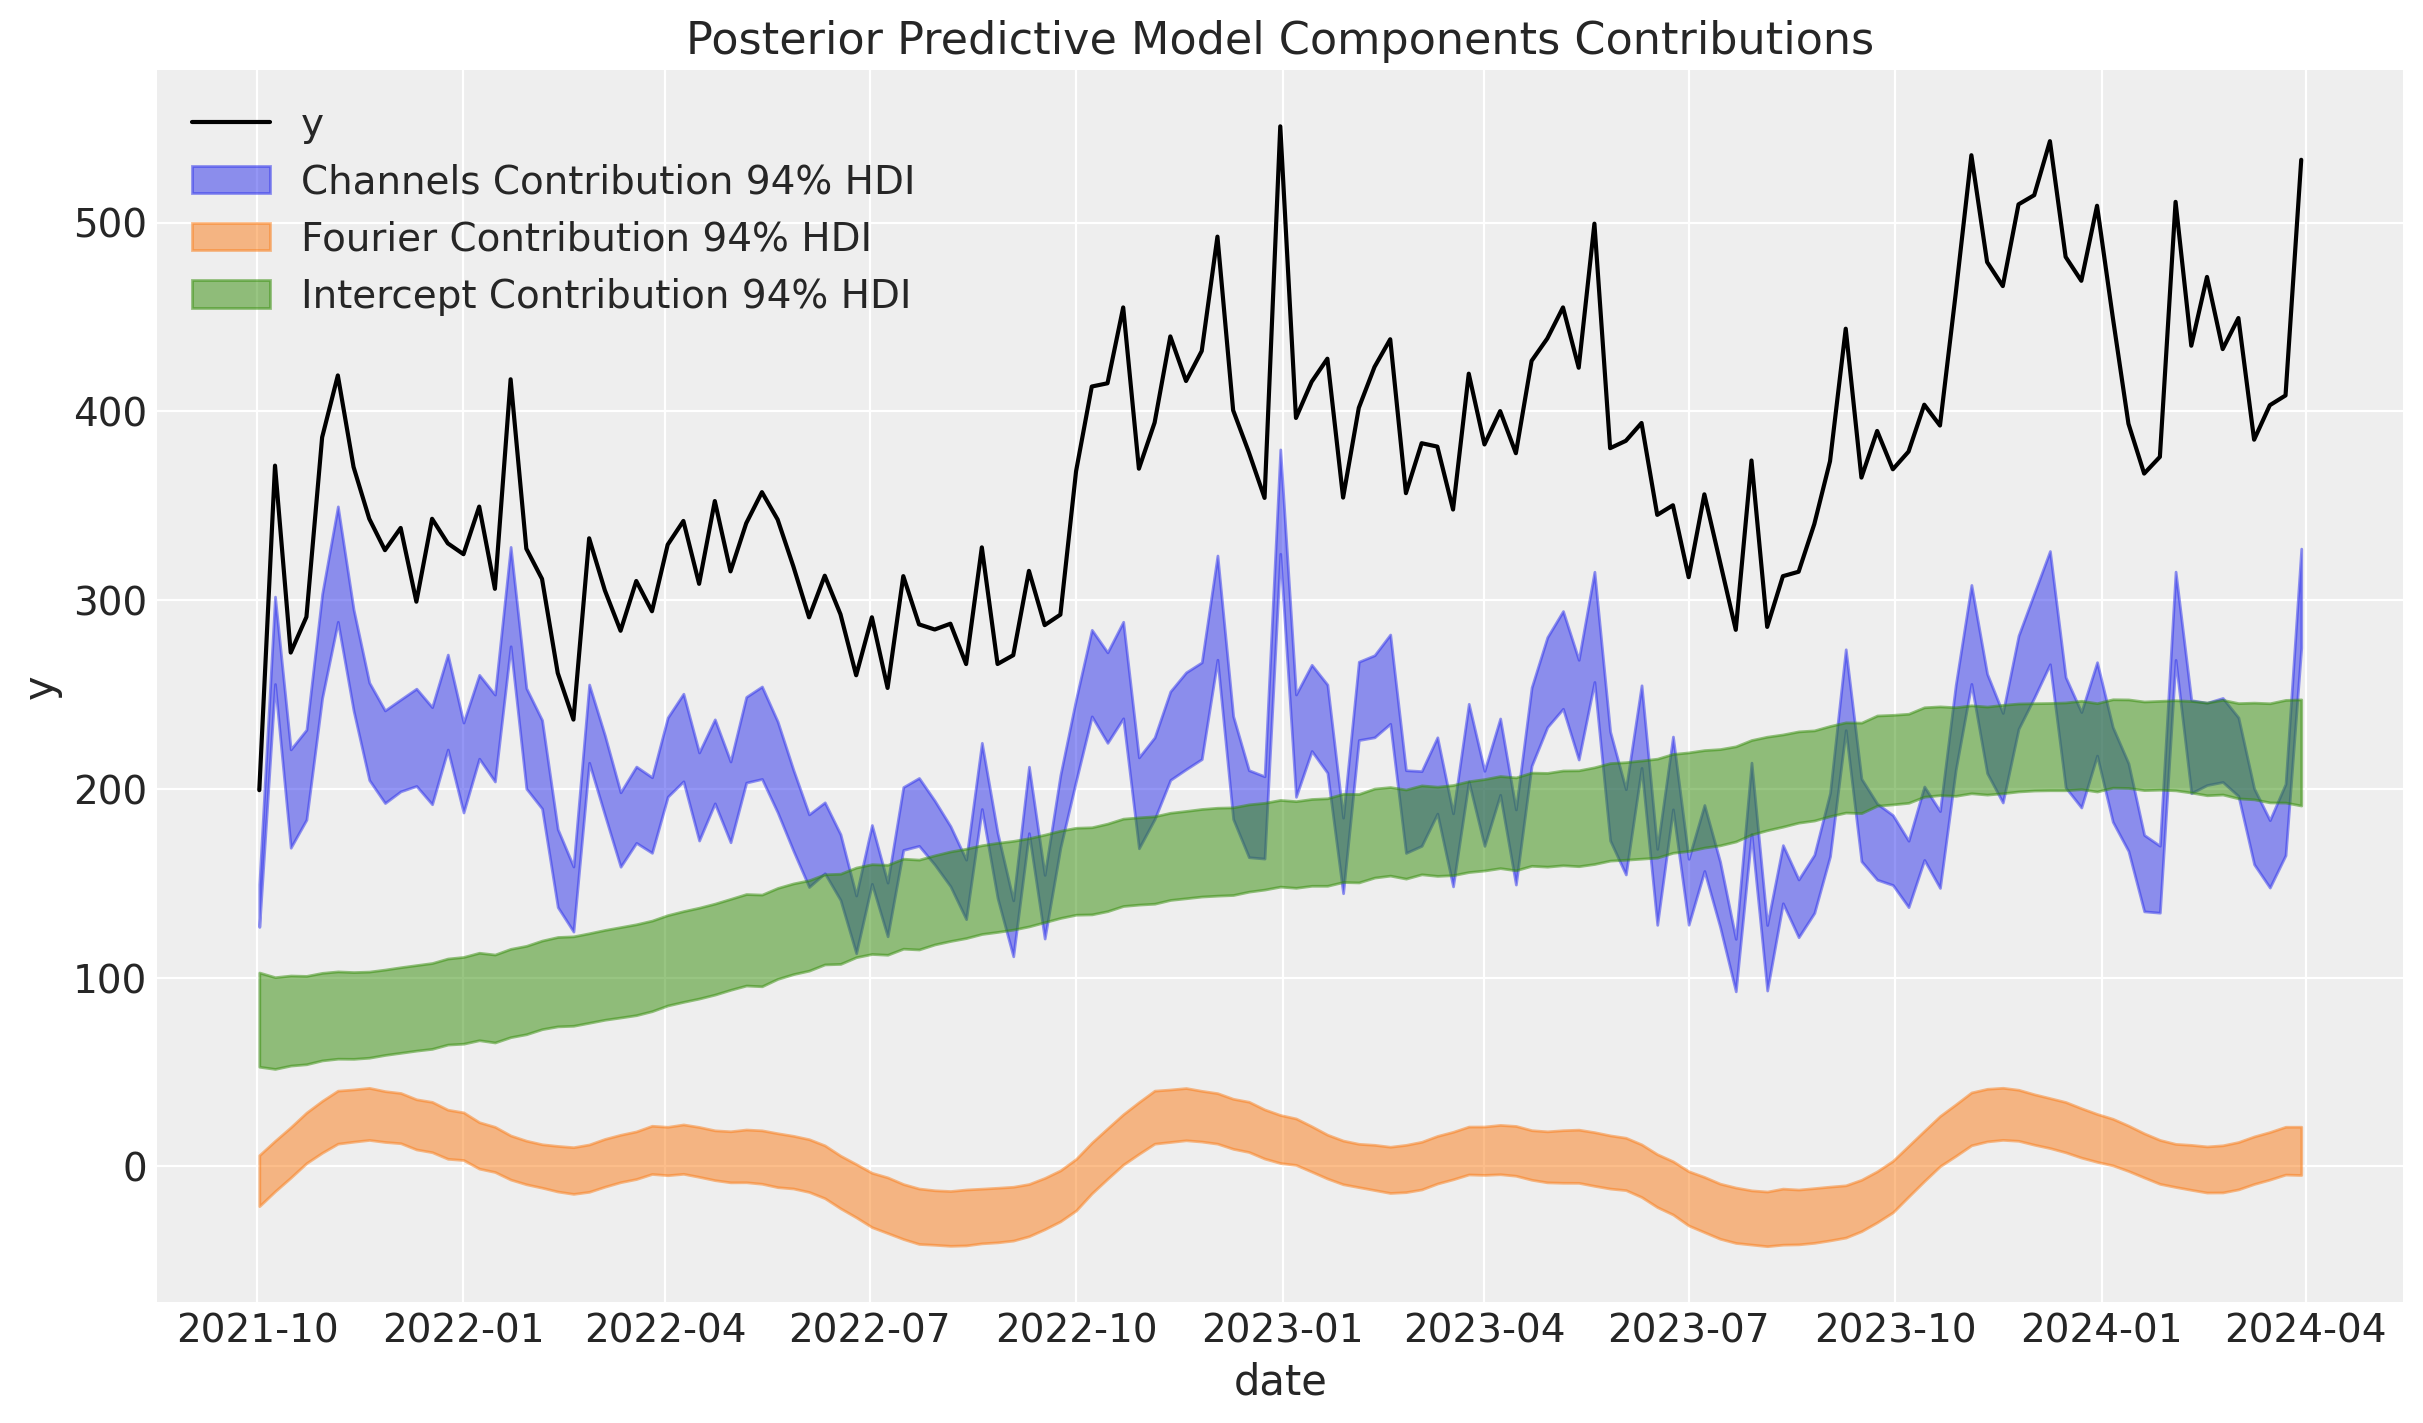

In [12]:
fig, ax = plt.subplots()

sns.lineplot(x="date", y="y", data=model_df, color="black", label="y", ax=ax)

az.plot_hdi(
    x=model_df["date"],
    y=mmm.idata["posterior"]["channel_contribution_original_scale"].sum(dim="channel"),
    smooth=False,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": "Channels Contribution 94% HDI"},
    ax=ax,
)

az.plot_hdi(
    x=model_df["date"],
    y=mmm.idata["posterior"]["fourier_contribution_original_scale"].sum(
        dim="fourier_mode"
    ),
    smooth=False,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": "Fourier Contribution 94% HDI"},
    ax=ax,
)

az.plot_hdi(
    x=model_df["date"],
    y=mmm.idata["posterior"]["intercept_contribution_original_scale"],
    smooth=False,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "Intercept Contribution 94% HDI"},
    ax=ax,
)

ax.legend()
ax.set(title="Posterior Predictive Model Components Contributions");

The results look very similar to the results from the original blog post. In particular, note that we were able to capture the non-linear trend.

Next, we look into the channel contributions against the true effects (which we know from the data generating process).

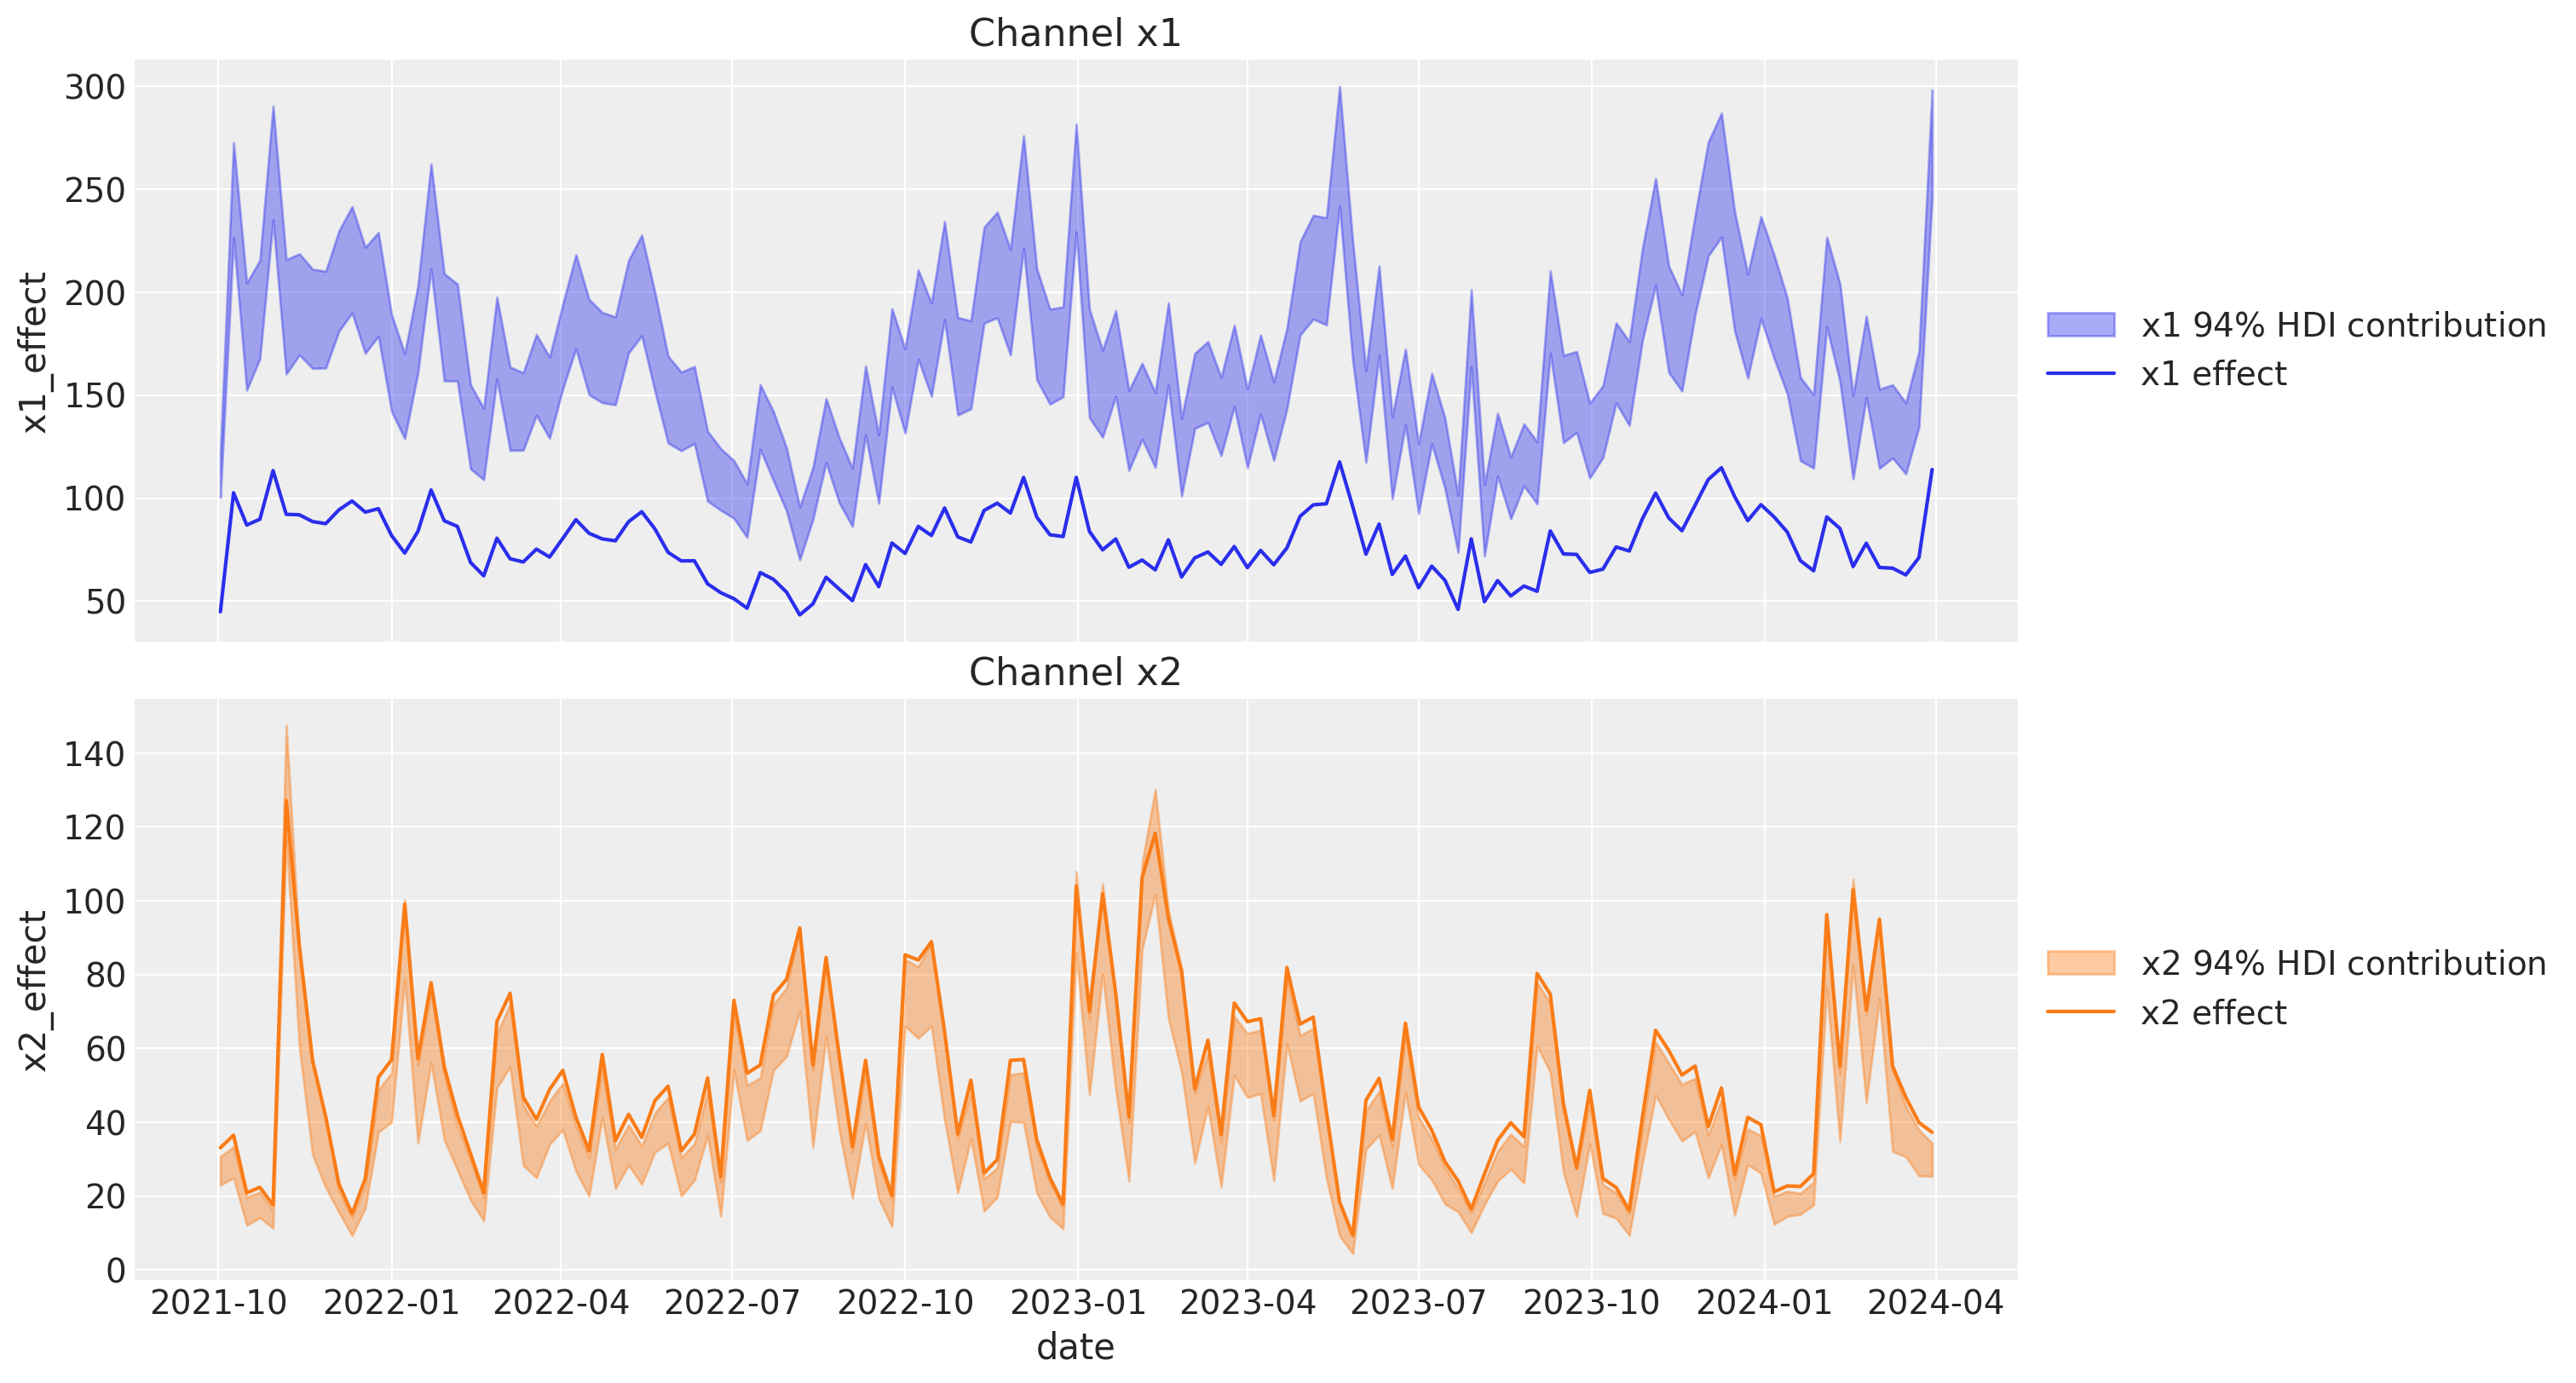

In [13]:
channels_contribution_original_scale = mmm.idata["posterior"][
    "channel_contribution_original_scale"
]
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi[
            "channel_contribution_original_scale"
        ].sel(channel=x, hdi="lower"),
        y2=channels_contribution_original_scale_hdi[
            "channel_contribution_original_scale"
        ].sel(channel=x, hdi="higher"),
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=f"{x} effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

We see that the contribution for `x1` is very different from the true effect. This is because the absence of the unobserved confounder `z`. For `x2`, the contribution is very similar to the true effect.

Finally, we can compute the ROAS for the `x1` and `x2` channels (again, ignoring the small carryover effect).

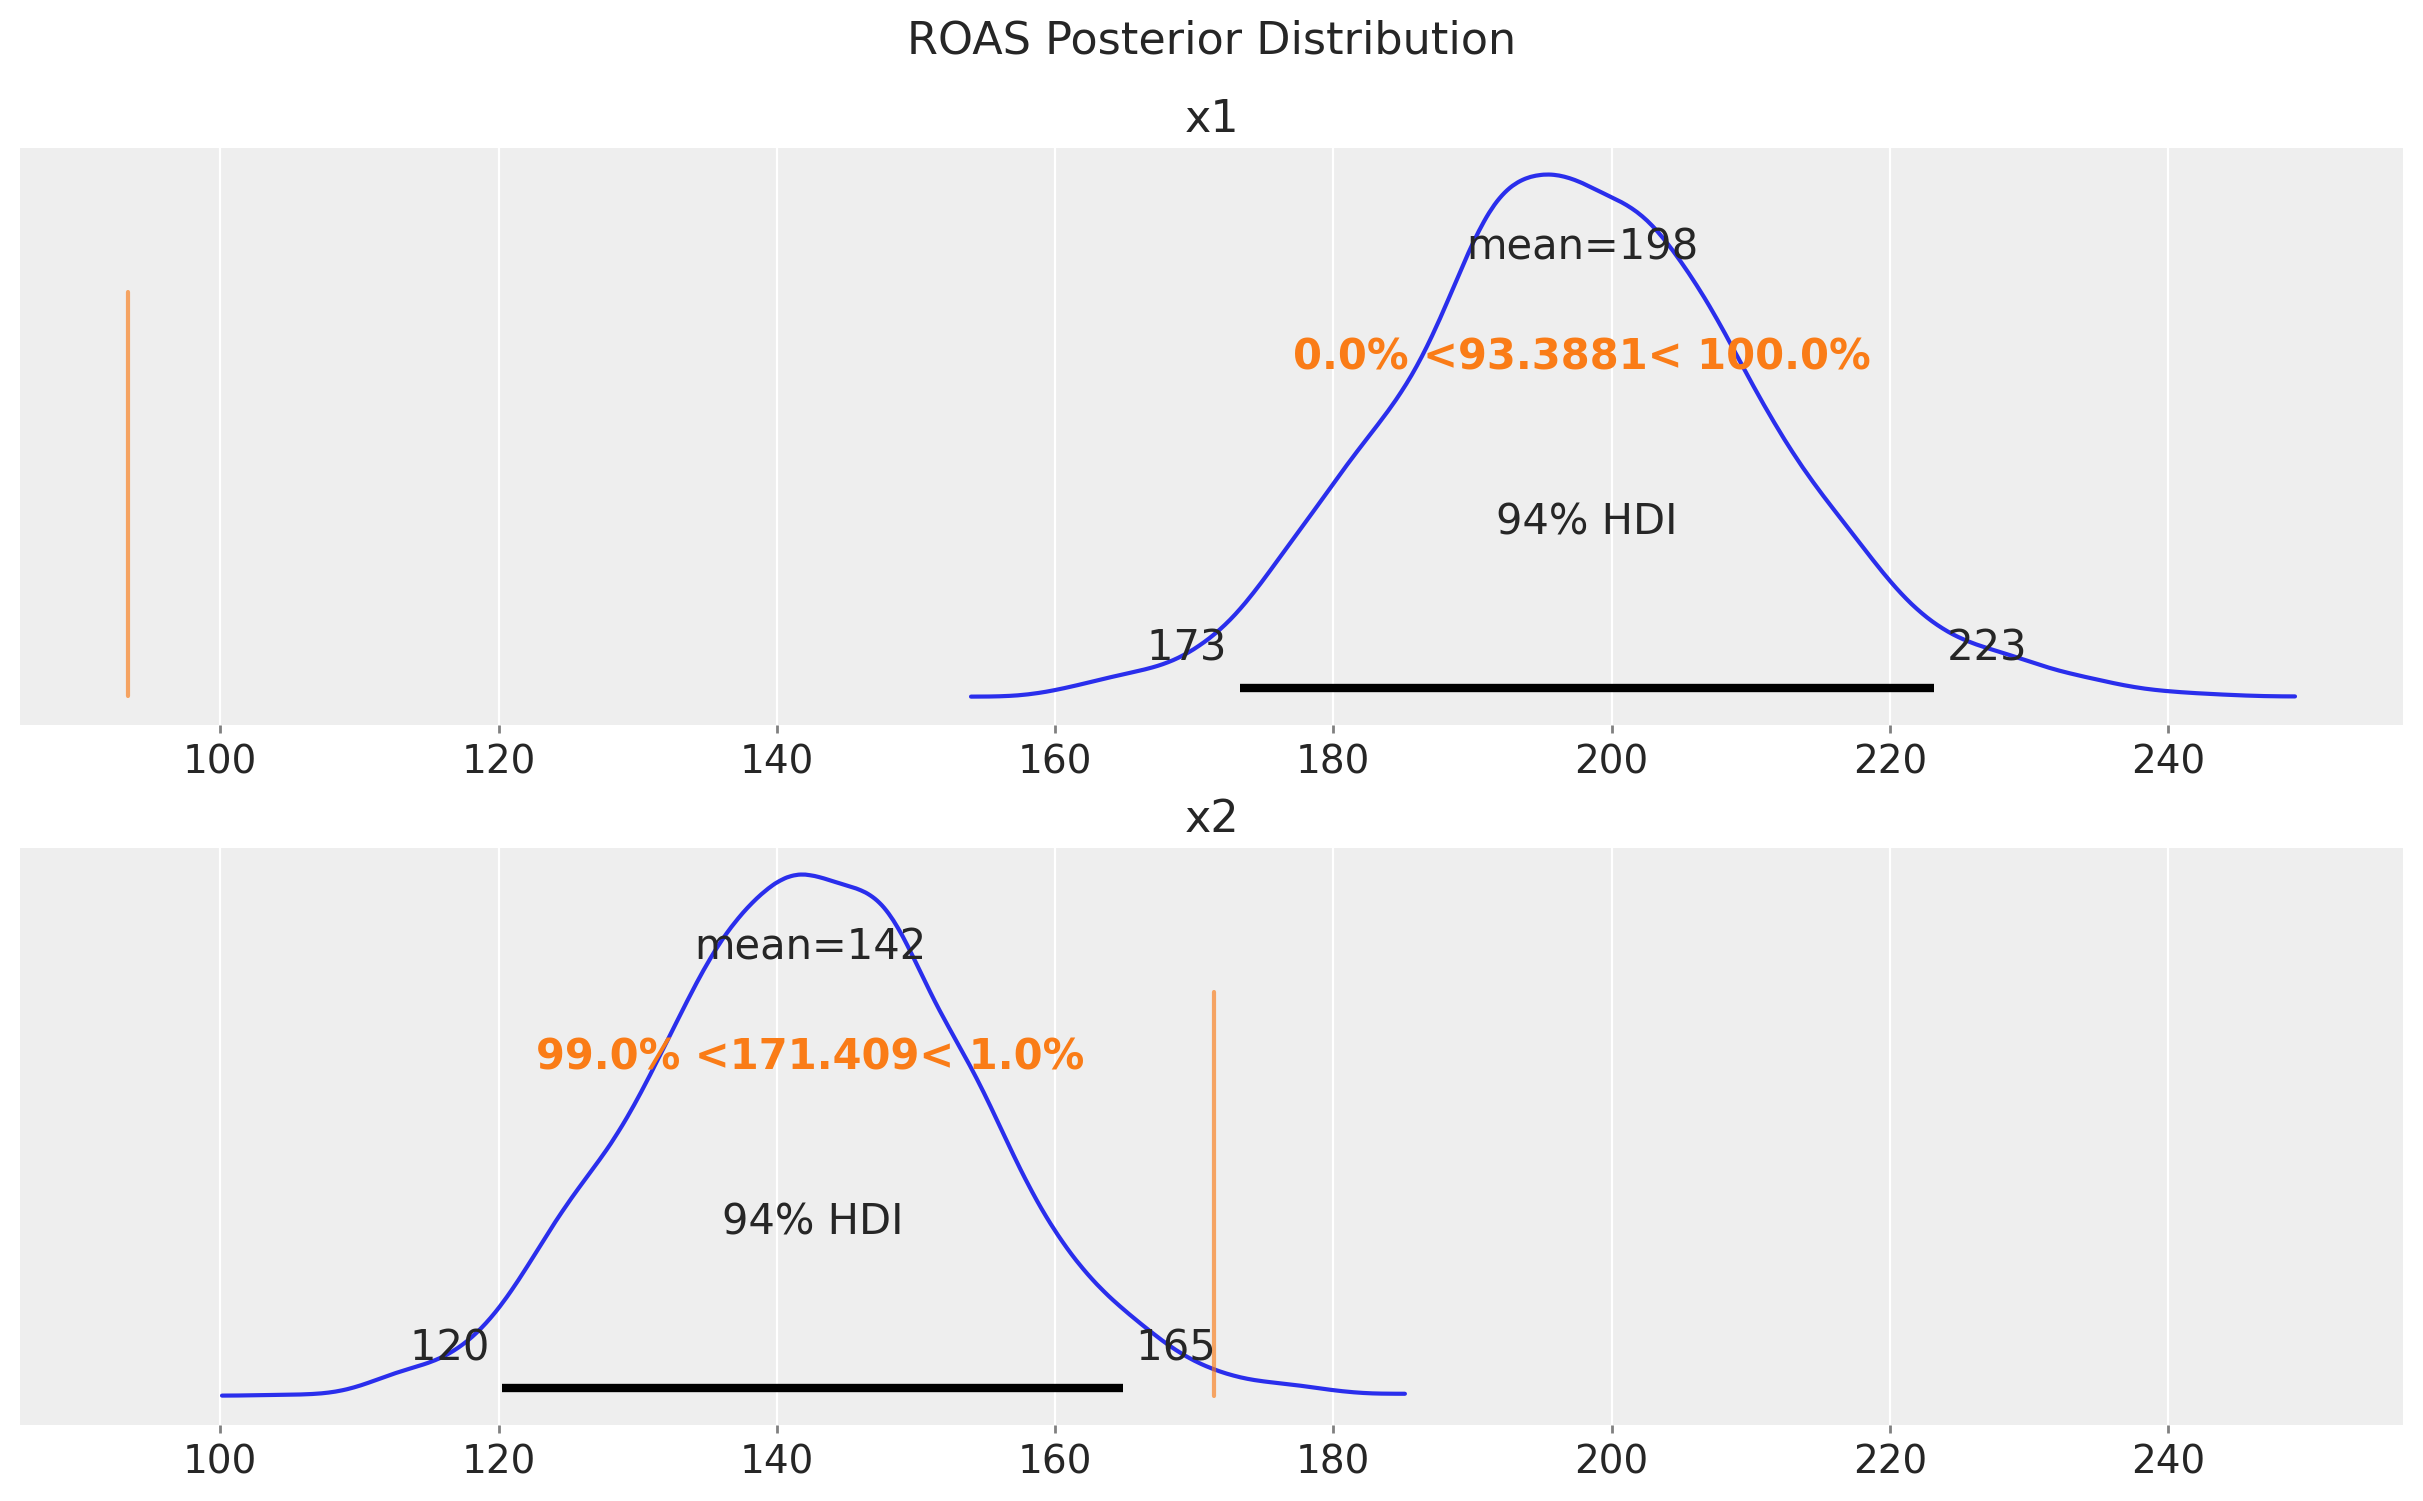

In [14]:
roas_posterior = (
    channels_contribution_original_scale.sum(dim="date")
    / model_df[["x1", "x2"]].sum().to_numpy()[np.newaxis, np.newaxis, :]
)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

az.plot_posterior(roas_posterior, ref_val=[true_roas_x1, true_roas_x2], ax=ax)
ax[0].set_title("x1")
ax[1].set_title("x2")
fig.suptitle("ROAS Posterior Distribution", fontsize=16, y=1.05);

We see that the ROAS for `x1` is very different from the true value. This is reflecting the bias induced by the unobserved confounder `z`. The models suggests that `x1` is more effective than `x2`, but we know from the data generating process that `x2` is more effective!

## Lift Test Model

Now we fit a model with some lift tests. We will use the same model configuration as before, but we free the priors of the beta channel coefficients as these are included in the saturation function parametrization. In general, we expect lift tests priors or associated custom likelihoods to be better than the cost share prior.

In [15]:
model_config = {
    "intercept": Prior("Normal", mu=200, sigma=20),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
    "gamma_fourier": Prior("Normal", mu=0, sigma=2, dims="fourier_mode"),
    "intercept_tvp_config": HSGPKwargs(
        m=50, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None
    ),
    "adstock_alpha": Prior("Beta", alpha=2, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=2, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=1.5, dims="channel"),
}

mmm_lift = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    target_column="y",
    time_varying_intercept=True,
    time_varying_media=False,
    yearly_seasonality=5,
    model_config=model_config,
)

# we need to build the model before adding the lift test measurements
mmm_lift.build_model(X, y)

```{admonition} Lift Tests
:class: tip

In a lift study, one temporarily changes the budget of a channel for a fixed period of time, and then uses some method (for example [CausalPy](https://causalpy.readthedocs.io/en/stable/)) to make inference about the change in sales directly caused by the adjustment.

A lift test is characterized by:

- `channel`: the channel that was tested
- `x`: pre-test channel spend
- `delta_x`: change made to x
- `delta_y`: inferred change in sales due to delta_x
- `sigma`: standard deviation of delta_y

An experiment characterized in this way can be viewed as two points on the saturation curve for the channel. 
```

Next assume we have ran two lift tests for the `x1` and `x2` channels. The results table looks like this:

In [16]:
df_lift_test = pd.DataFrame(
    data={
        "channel": ["x1", "x2", "x1", "x2"],
        "x": [0.25, 0.1, 0.8, 0.25],
        "delta_x": [0.25, 0.1, 0.8, 0.25],
        "delta_y": [
            true_roas_x1 * 0.25,
            true_roas_x2 * 0.1,
            true_roas_x1 * 0.8,
            true_roas_x2 * 0.25,
        ],
        "sigma": [3, 3, 3, 3],
    }
)

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,x1,0.25,0.25,23.347033,3
1,x2,0.10,0.10,17.140880,3
2,x1,0.80,0.80,74.710505,3
3,x2,0.25,0.25,42.852201,3


```{admonition} Comparison with the original blog post
:class: tip

Note that we have added the true ROAS for the `x1` and `x2` channels implicit to the `df_lift_test` table. We add them multiplying the `delta_y` as this is what we would have observed if we had run the lift test (or similar values).

In the simulation [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/), the author included these "true" values into the prior for the ROAS.
```

Now, we fit the model with the lift test measurements.

In [17]:
mmm_lift.add_lift_test_measurements(df_lift_test=df_lift_test)

In [18]:
mmm_lift.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "fourier_contribution",
        "intercept_contribution",
    ]
)
_ = mmm_lift.fit(X, y, **fit_kwargs)
_ = mmm_lift.sample_posterior_predictive(
    X, extend_idata=True, combined=True, random_seed=rng
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,0,0.09,63
,2500,0,0.08,63
,2500,0,0.08,63
,2500,0,0.08,63


Output()

Sampling: [lift_measurements, y]


Output()

Again, we verify that we do not have divergent transitions.

In [19]:
# Number of diverging samples
mmm_lift.idata["sample_stats"]["diverging"].sum().item()

Let's plot the components contributions as we did before.

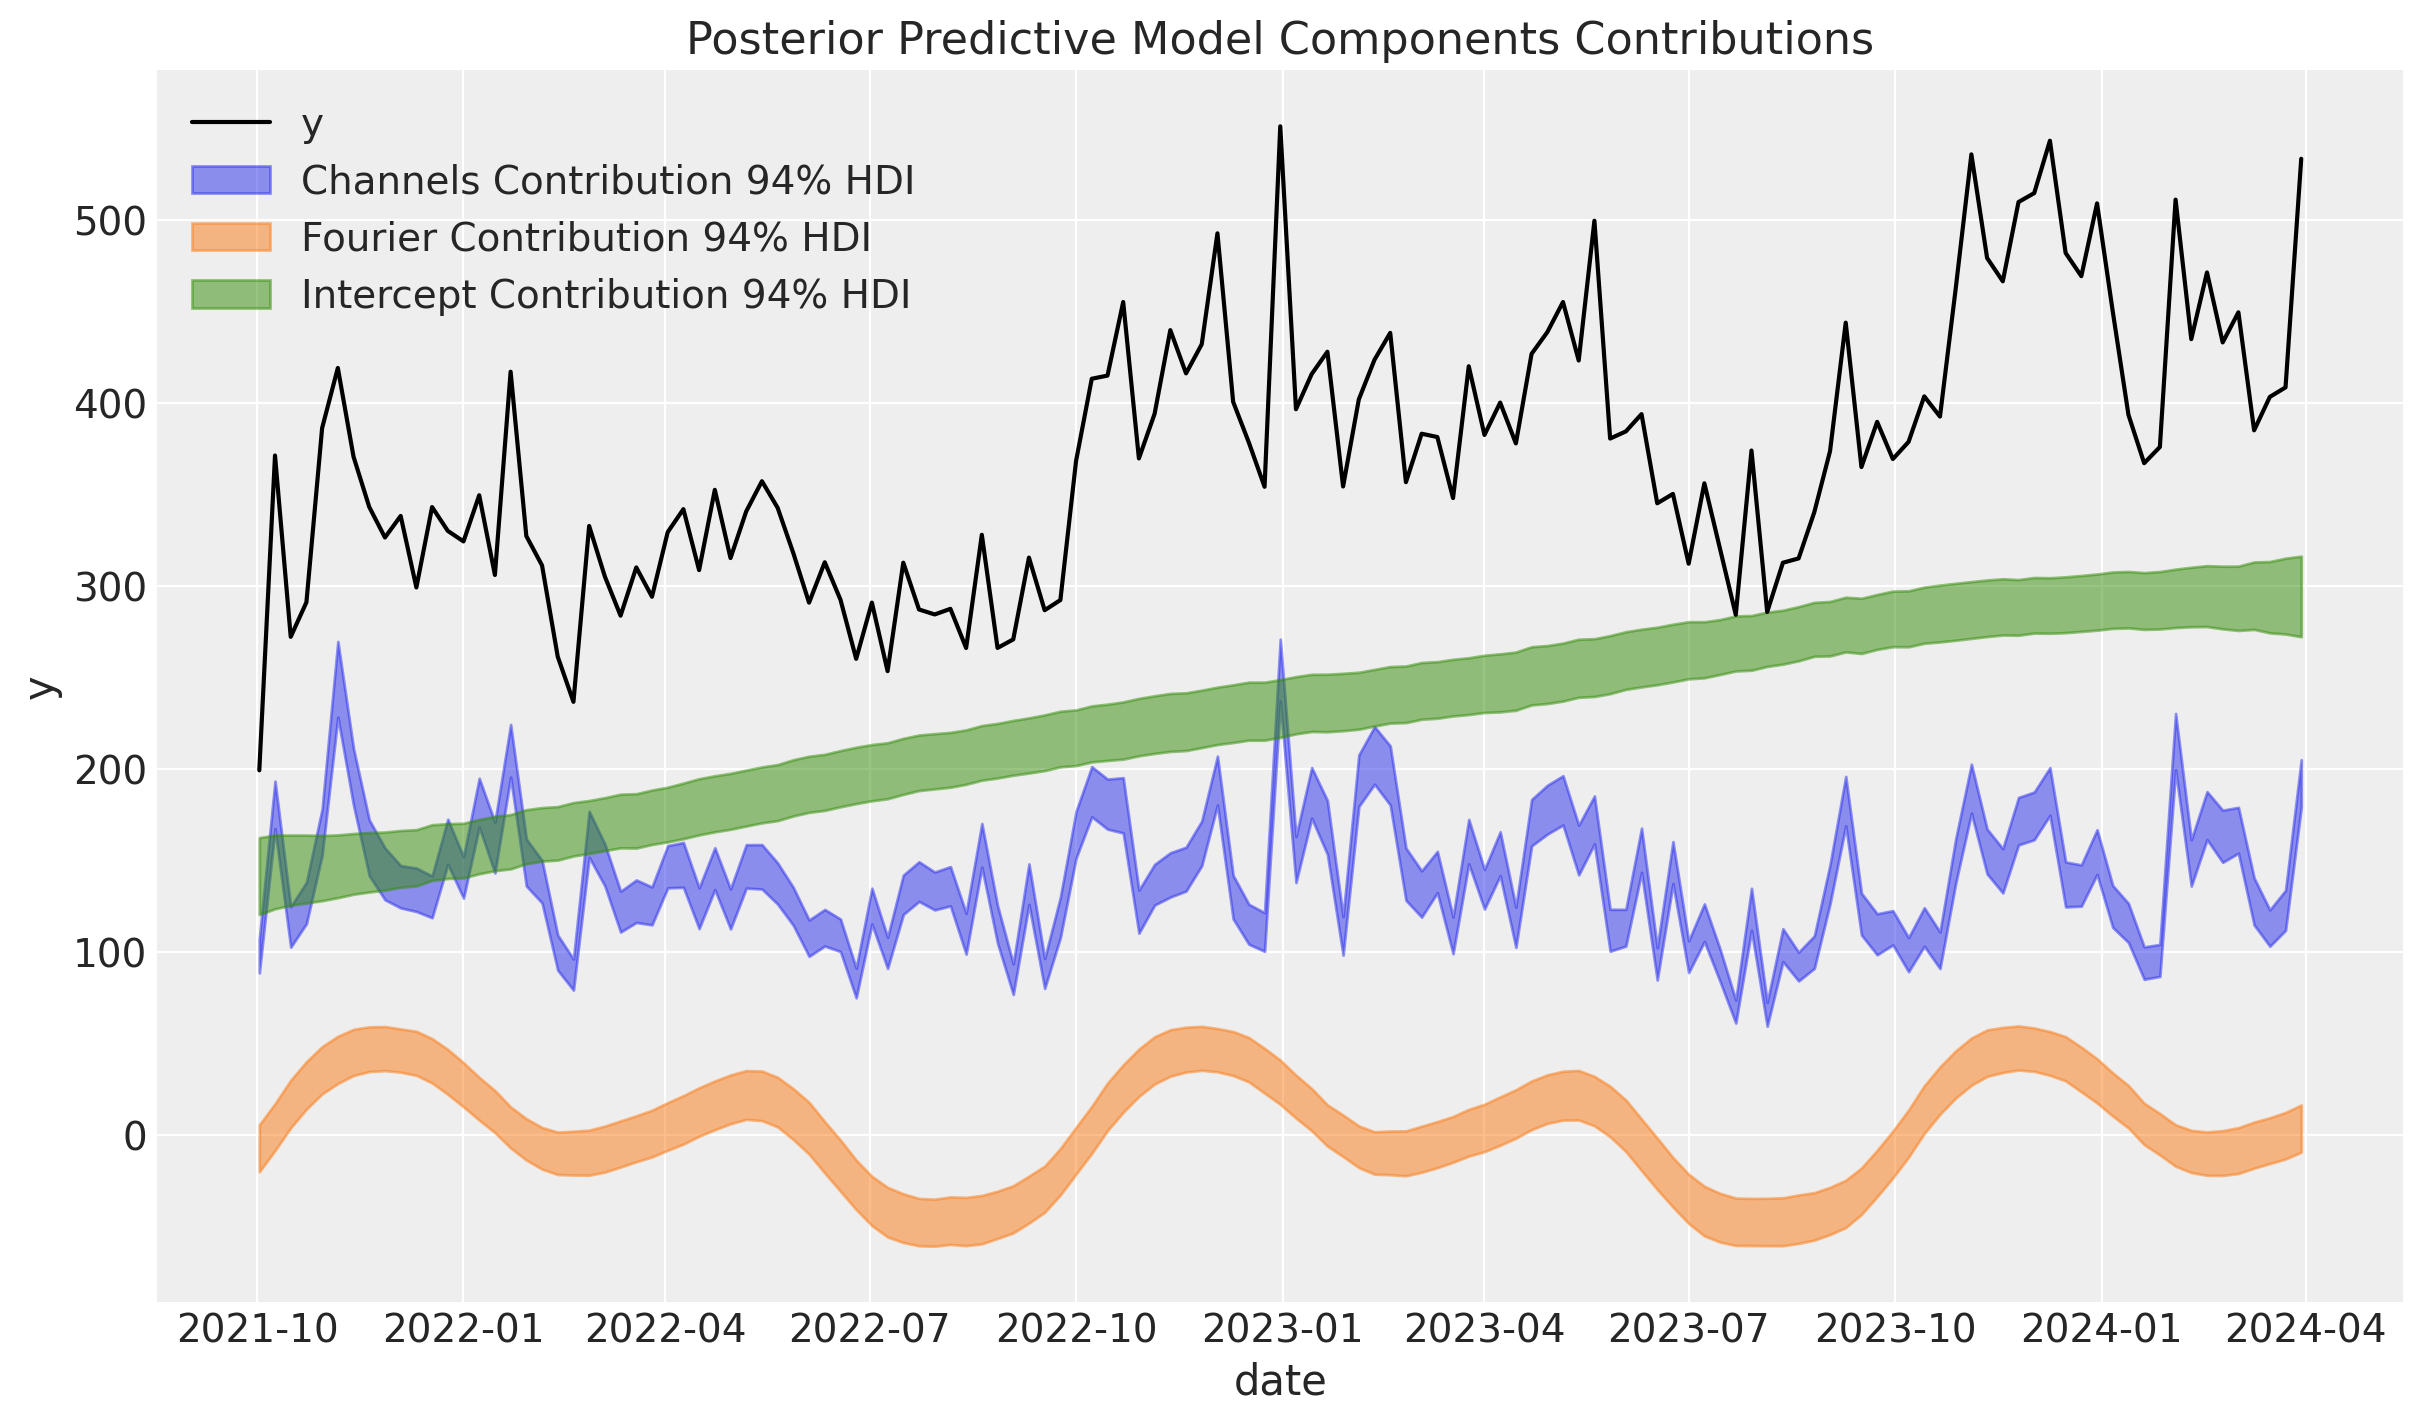

In [20]:
fig, ax = plt.subplots()

sns.lineplot(x="date", y="y", data=model_df, color="black", label="y", ax=ax)

az.plot_hdi(
    x=model_df["date"],
    y=mmm_lift.idata["posterior"]["channel_contribution_original_scale"].sum(
        dim="channel"
    ),
    smooth=False,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": "Channels Contribution 94% HDI"},
    ax=ax,
)

az.plot_hdi(
    x=model_df["date"],
    y=mmm_lift.idata["posterior"]["fourier_contribution_original_scale"].sum(
        dim="fourier_mode"
    ),
    smooth=False,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": "Fourier Contribution 94% HDI"},
    ax=ax,
)

az.plot_hdi(
    x=model_df["date"],
    y=mmm_lift.idata["posterior"]["intercept_contribution_original_scale"],
    smooth=False,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "Intercept Contribution 94% HDI"},
    ax=ax,
)

ax.legend()
ax.set(title="Posterior Predictive Model Components Contributions");

As before, we have recovered the non-linear trend component and the yearly seasonality.

Now, let's compute the channel contributions to the true ones.

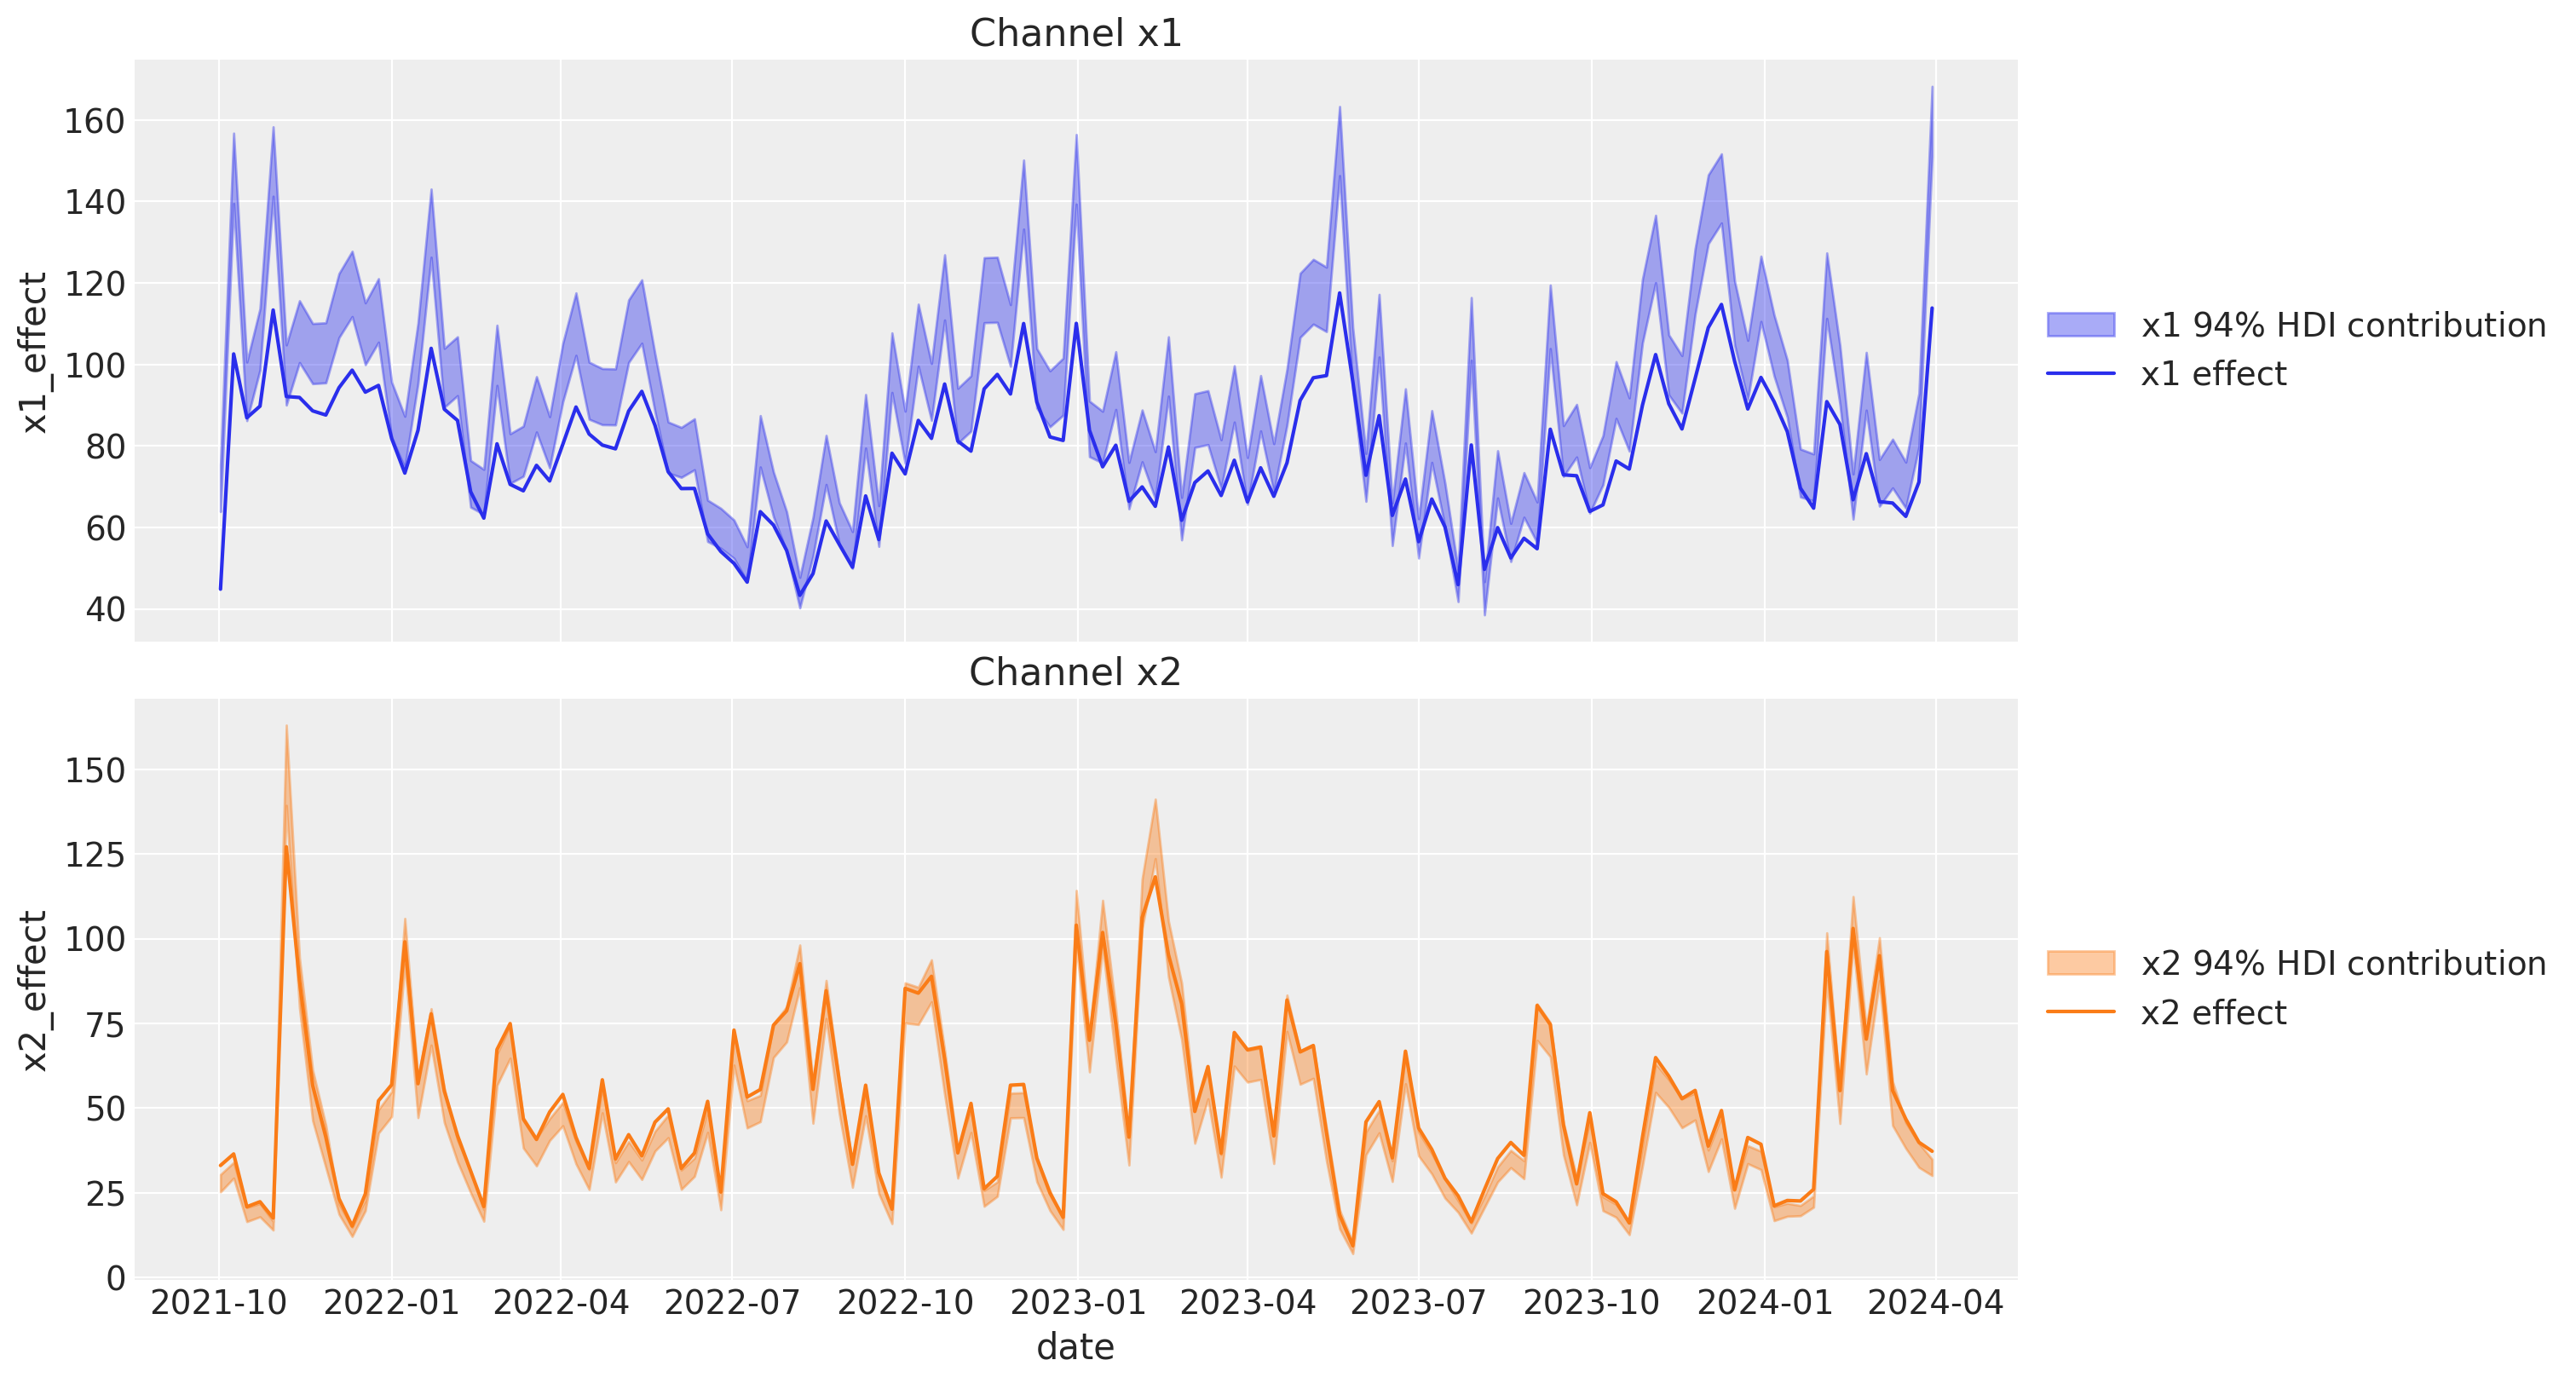

In [21]:
channels_contribution_original_scale = mmm_lift.idata["posterior"][
    "channel_contribution_original_scale"
]
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale, hdi_prob=0.8
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi[
            "channel_contribution_original_scale"
        ].sel(channel=x, hdi="lower"),
        y2=channels_contribution_original_scale_hdi[
            "channel_contribution_original_scale"
        ].sel(channel=x, hdi="higher"),
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=f"{x} effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

The contributions look much better and they are very close to the ones of the original blog post! Hence, **these two approaches are very similar**. However note that the PyMC-Marketing approach is more flexible as it allows to enrich the estimates with more test and different media spends to have a better understanding of the saturation effect.

Finally, let's compute the ROAS for the `x1` and `x2` channels.

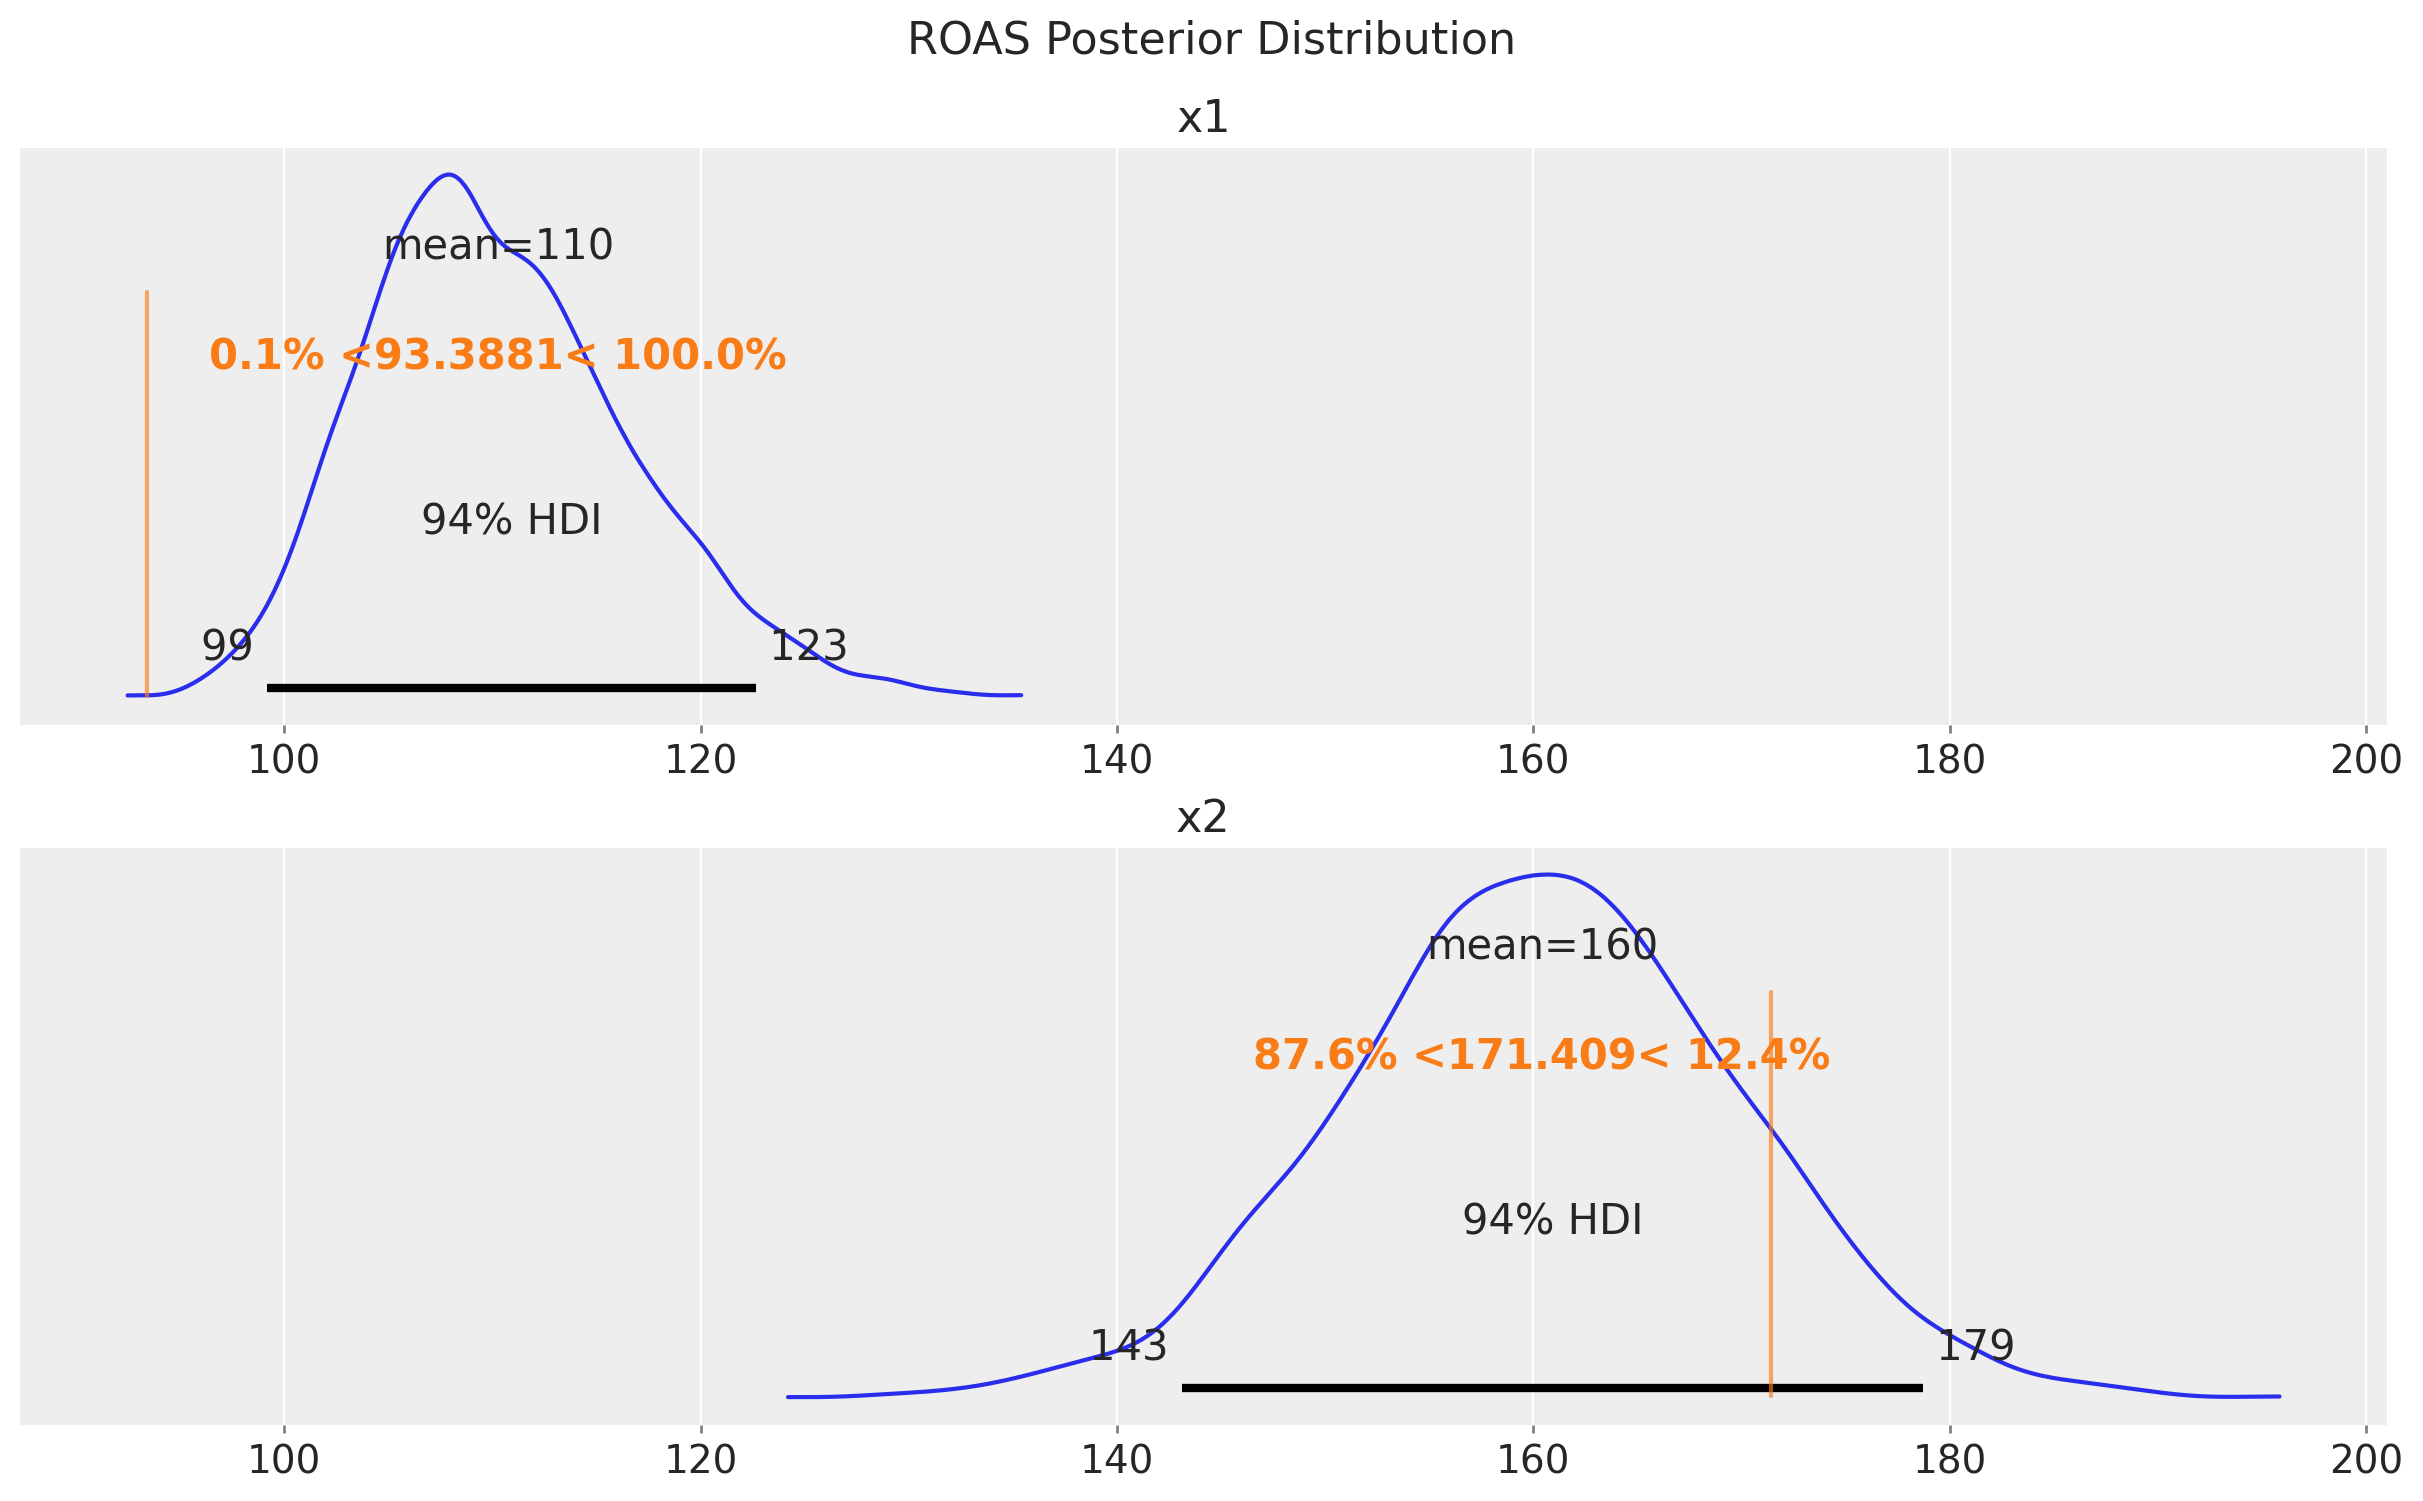

In [22]:
roas_posterior = (
    channels_contribution_original_scale.sum(dim="date")
    / model_df[["x1", "x2"]].sum().to_numpy()[np.newaxis, np.newaxis, :]
)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

az.plot_posterior(roas_posterior, ref_val=[true_roas_x1, true_roas_x2], ax=ax)
ax[0].set_title("x1")
ax[1].set_title("x2")
fig.suptitle("ROAS Posterior Distribution", fontsize=16, y=1.05);

The estimates are very very close to the true ROAS! We do get from the model that `x2` is more effective than `x1`, which is aligned with the lift test results!

## Conclusion

In this notebook, we have seen a concrete example of how media mix models can provide bias estimates when we have unobserved confounders in the model specification. Ideally, we'd add the confounder, but in the absence of that, we need to provide a reality anchor to the model to have meaningful estimates. We have shown that the PyMC-Marketing approach of adding lift test measurements to the model is very similar to the one proposed in the paper [Media Mix Model Calibration With Bayesian Priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/) and the blog post [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/).
However, the PyMC-Marketing approach is more flexible as it allows enriching the estimates with more lift tests and different media spending to better understand the saturation effect. We have also seen why it is essential to include the lift test measurements in the model to account for the unobserved confounders and better understand the saturation effect.

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor,numpyro

Last updated: Mon, 12 Jan 2026

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.9.0

pymc_marketing: 0.17.1
pytensor      : 2.36.3
numpyro       : 0.19.0

arviz         : 0.23.0
graphviz      : 0.21
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
pymc_extras   : 0.7.0
pymc_marketing: 0.17.1
seaborn       : 0.13.2

Watermark: 2.6.0

